In [1]:
import datascience as ds
from datascience import are
import datetime
import numpy as np
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score, zero_one_loss
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 7.5
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

### Prepare Taxi Data

In [3]:
raw_taxi_data = ds.Table.read_table("./SF_taxi_data.csv")
raw_taxi_data

id,departure time,arrival time,fare ($),num,dep lon,dep lat,arr lon,arr lat,deptaz,arrtaz,dist (miles)
0,9/1/12 0:11,9/1/12 0:20,13.2,1,-122.414,37.8027,-122.421,37.7854,38,30,1.98084
1,9/1/12 0:23,9/1/12 0:31,10.65,1,-122.42,37.7861,-122.435,37.7622,30,94,2.40224
2,9/1/12 0:45,9/1/12 0:49,9,1,-122.415,37.7747,-122.408,37.7826,10,11,0.479348
3,9/1/12 0:41,9/1/12 0:54,13.95,2,-122.419,37.8066,-122.415,37.7781,40,10,2.12241
4,9/1/12 1:09,9/1/12 1:13,7.35,1,-122.43,37.7978,-122.418,37.789,45,32,1.03807
5,9/1/12 1:40,9/1/12 1:52,11.75,1,-122.433,37.7841,-122.411,37.787,77,7,0.960851
6,9/1/12 2:49,9/1/12 2:51,5.15,1,-122.409,37.7856,-122.412,37.791,7,29,0.414315
7,9/1/12 3:29,9/1/12 3:47,43.65,1,-122.403,37.7927,-122.386,37.6181,2,239,14.5105
8,9/1/12 0:33,9/1/12 0:57,46.75,1,-122.387,37.6174,-122.407,37.7889,239,5,14.2747
9,9/1/12 4:39,9/1/12 4:43,6.25,1,-122.422,37.7977,-122.418,37.789,34,31,0.685312


#### Convert times to Python Datetimes

In [4]:
raw_taxi_data['Dep. Datetime'] = raw_taxi_data.select('departure time').apply(lambda x : datetime.datetime.strptime(x[0], "%m/%d/%y %H:%M"))
raw_taxi_data['Arr. Datetime'] = raw_taxi_data.select('arrival time').apply(lambda x : datetime.datetime.strptime(x[0], "%m/%d/%y %H:%M"))

#### Keep only trips with one passenger and $3.50+ fare

In [5]:
taxi_data = raw_taxi_data.where('num', are.equal_to(1)).where('fare ($)', are.above_or_equal_to(3.5))

#### Calculate Extra Fare, Trip Duration

In [6]:
taxi_data["Extra Fare"] = taxi_data['fare ($)'] - (3.5 + 0.55 * 5 * taxi_data['dist (miles)'] - 0.55)
taxi_data["Trip Duration"] = taxi_data["Arr. Datetime"] - taxi_data["Dep. Datetime"]
taxi_data["Trip Duration (seconds)"] = taxi_data.select('Trip Duration').apply(lambda x : x[0].total_seconds())

#### Calculate Time of Day, Hour of Day, Day of the Week

In [7]:
def time_to_delta(t):
    return datetime.timedelta(hours=t.hour, minutes=t.minute, seconds=t.second)

In [8]:
taxi_data["Time of day"] = taxi_data.select("Dep. Datetime").apply(lambda x : x[0].time())
taxi_data["Time of day (seconds)"] = taxi_data.select("Time of day").apply(lambda x: time_to_delta(x[0]).total_seconds())
taxi_data["Hour of day"] = taxi_data.select("Time of day").apply(lambda x : x[0].hour)
taxi_data["Day of the week"] = taxi_data.select("Dep. Datetime").apply(lambda x : x[0].date().weekday())

#### Calculate Extra Distance Traveled

In [9]:
def distance_on_sphere(long1, lat1, long2, lat2):

    # Convert latitude and longitude to spherical coordinates in radians.
    degrees_to_radians = np.pi/180.0
        
    # phi = 90 - latitude
    phi1 = (90.0 - lat1)*degrees_to_radians
    phi2 = (90.0 - lat2)*degrees_to_radians
        
    # theta = longitude
    theta1 = long1*degrees_to_radians
    theta2 = long2*degrees_to_radians
        
    # We can compute spherical distance from spherical coordinates.
    cos = (np.sin(phi1)*np.sin(phi2)*np.cos(theta1-theta2)+
           np.cos(phi1)*np.cos(phi2))
    arc = np.arccos( cos )

    # Multiply arc by the radius of the earth to get length.
    return 3960.*arc #to get distance in miles

In [10]:
taxi_data["Approx. Actual Distance"] = taxi_data.apply(distance_on_sphere, ["dep lon", "dep lat", "arr lon", "arr lat"])
taxi_data["Actual - Approx. Distance"] = taxi_data["dist (miles)"] - taxi_data["Approx. Actual Distance"]

/srv/app/venv/lib/python3.6/site-packages/datascience/tables.py:361: FutureWarning: column lists are deprecated; pass each as an argument
  "column lists are deprecated; pass each as an argument", FutureWarning)


### Compare "Extra" Travel Distance against the day of the week

In [11]:
taxi_data_weekdays = taxi_data.where("Day of the week", are.below(5))
taxi_data_weekends = taxi_data.where("Day of the week", are.above_or_equal_to(5))

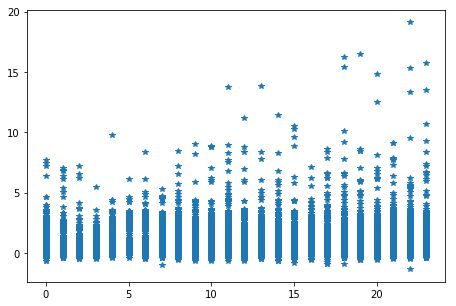

In [12]:
plt.plot(taxi_data_weekdays["Hour of day"], taxi_data_weekdays["Actual - Approx. Distance"], "*")

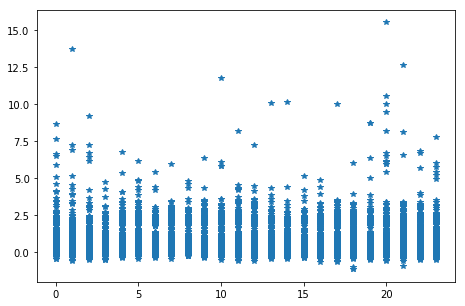

In [13]:
plt.plot(taxi_data_weekends["Hour of day"], taxi_data_weekends["Actual - Approx. Distance"], "*")

### Visualize Additional Distance over the Hour and Day

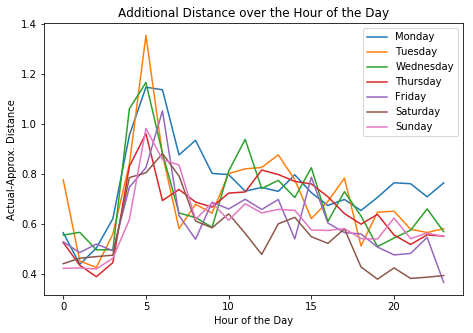

In [14]:
taxi_data_monday=taxi_data.where("Day of the week", 0).select("Hour of day", "Actual - Approx. Distance").group("Hour of day", np.mean)
taxi_data_tuesday=taxi_data.where("Day of the week", 1).select("Hour of day", "Actual - Approx. Distance").group("Hour of day", np.mean)
taxi_data_wednesday=taxi_data.where("Day of the week", 2).select("Hour of day", "Actual - Approx. Distance").group("Hour of day", np.mean)
taxi_data_thursday=taxi_data.where("Day of the week", 3).select("Hour of day", "Actual - Approx. Distance").group("Hour of day", np.mean)
taxi_data_friday=taxi_data.where("Day of the week", 4).select("Hour of day", "Actual - Approx. Distance").group("Hour of day", np.mean)
taxi_data_saturday=taxi_data.where("Day of the week", 5).select("Hour of day", "Actual - Approx. Distance").group("Hour of day", np.mean)
taxi_data_sunday=taxi_data.where("Day of the week", 6).select("Hour of day", "Actual - Approx. Distance").group("Hour of day", np.mean)


plt.plot(taxi_data_monday["Hour of day"], taxi_data_monday["Actual - Approx. Distance mean"], "-")
plt.plot(taxi_data_tuesday["Hour of day"], taxi_data_tuesday["Actual - Approx. Distance mean"], "-")
plt.plot(taxi_data_wednesday["Hour of day"], taxi_data_wednesday["Actual - Approx. Distance mean"], "-")
plt.plot(taxi_data_thursday["Hour of day"], taxi_data_thursday["Actual - Approx. Distance mean"], "-")
plt.plot(taxi_data_friday["Hour of day"], taxi_data_friday["Actual - Approx. Distance mean"], "-")
plt.plot(taxi_data_saturday["Hour of day"], taxi_data_saturday["Actual - Approx. Distance mean"], "-")
plt.plot(taxi_data_sunday["Hour of day"], taxi_data_sunday["Actual - Approx. Distance mean"], "-")
xlabel=plt.xlabel("Hour of the Day")
ylabel=plt.ylabel("Actual-Approx. Distance")
plt.legend(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], loc="upper right")
plt.title("Additional Distance over the Hour of the Day")
plt.savefig("Additional Distance over the Hour of the Day")


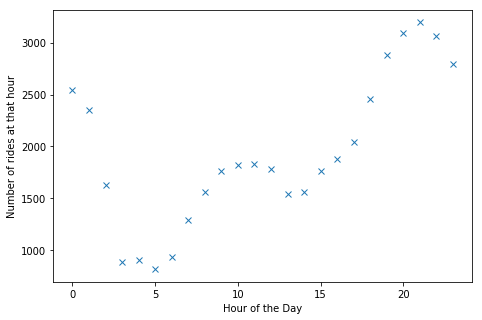

In [119]:
#The total number of rides at every hour
hr=taxi_data.group("Hour of day")
plt.plot(hr["Hour of day"], hr["count"], "x")
xlabel=plt.xlabel("Hour of the Day")
ylabel=plt.ylabel("Number of rides at that hour")

### Where Most Trips Depart From Over Hour of the Day
To understand congestion

In [117]:
# take the max value of the count of deptaz per hour

max_deptaz= ds.make_array()
for i in range(24):
    mx=taxi_data.where("Hour of day", i).group("deptaz").sort("count", descending=True).column(0).item(0)
    max_deptaz=np.append(max_deptaz, mx)
max_deptaz



array([ 239.,    7.,    7.,    7.,   18.,    8.,    7.,   12.,    7.,
        239.,  239.,  239.,  239.,  239.,  239.,  239.,  239.,  239.,
        239.,  239.,  239.,  239.,  239.,  239.])

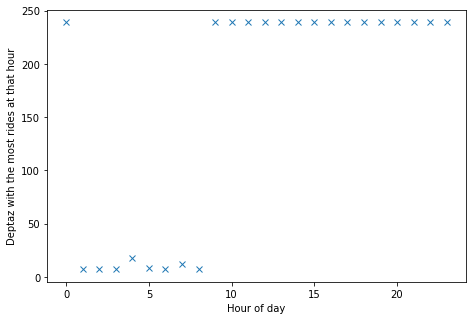

In [118]:
plt.plot(np.unique(taxi_data.column("Hour of day")), max_deptaz, "x")
plt.xlabel("Hour of day")
plt.ylabel("Deptaz with the most rides at that hour")

### Visualize Where Most Trips Depart From

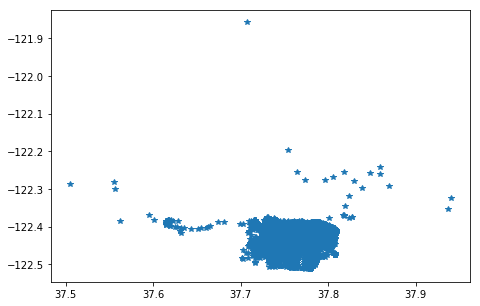

In [17]:
taxi_data_df = taxi_data.to_df()
plt.plot(taxi_data["dep lat"], taxi_data["dep lon"], "*")

### Compare Number of Rides over Hour of the Day

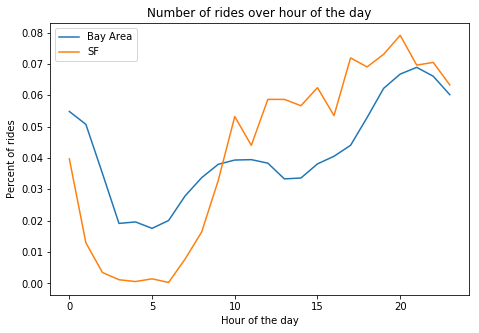

In [18]:
hour_df = taxi_data.group("Hour of day")
hour_df_sfo = taxi_data.where("deptaz", 239).group("Hour of day")
plt.plot(hour_df["Hour of day"], hour_df["count"] / np.sum(hour_df["count"]), hour_df_sfo["Hour of day"], hour_df_sfo["count"] / np.sum(hour_df_sfo["count"]))
plt.title("Number of rides over hour of the day")
plt.ylabel("Percent of rides")
plt.legend(["Bay Area", "SF"], loc="upper left")
plt.xlabel("Hour of the day")


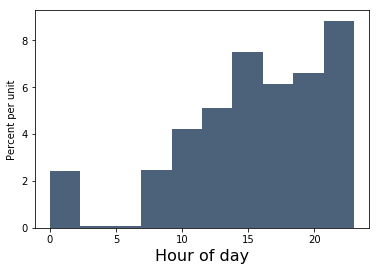

In [19]:
hour_df = taxi_data.where("deptaz", 239).select("Hour of day").hist()

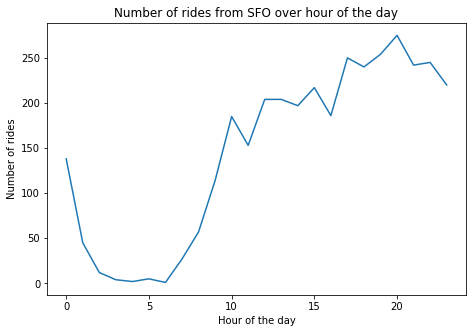

In [20]:
hour_df = taxi_data.where("deptaz", 239).group("Hour of day")
plt.plot(hour_df["Hour of day"], hour_df["count"])
plt.title("Number of rides from SFO over hour of the day")
plt.ylabel("Number of rides")
plt.xlabel("Hour of the day")

### Linear Regression on Distance, Duration v. Extra Fare

In [21]:
def get_training_and_test(data):
    training_data = data.where('Dep. Datetime', are.below_or_equal_to(datetime.datetime(year=2012,month=9,day=10)))
    test_data = data.where('Dep. Datetime', are.above(datetime.datetime(year=2012,month=9,day=10))).where('Dep. Datetime', are.below_or_equal_to(datetime.datetime(year=2012,month=9,day=17)))
    
    return training_data, test_data

In [22]:
def plot_regression(regr, X_test, Y_test, x_axis, y_axis, plot_base_formula=False, X_training=None, Y_training=None, title=""):
    plt.plot(X_test, Y_test, "bx")
    
    xlim_test = plt.gca().get_xlim()
    ylim_test = plt.gca().get_ylim()
    
    xlim = xlim_test
    ylim = ylim_test
    if X_training != None and Y_training != None:
        plt.plot(X_training, Y_training, "mx")

        xlim_train = plt.gca().get_xlim()
        ylim_train = plt.gca().get_ylim()
    
        xlim = max(xlim_test, xlim_train)
        ylim = max(ylim_test, ylim_train)
    
    # xlim = (max(xlim[0], 0), xlim[1])
    # ylim = (max(ylim[0], 0), ylim[1])

    theta = (regr.coef_[0][0], regr.intercept_[0])
    if not plot_base_formula:
        plt.plot(X_test, Y_test, "bx", xlim, [theta[0]*xlim[0]+theta[1], theta[0]*xlim[1]+theta[1]], 'g-')
        plt.legend(["Observed days", "", "Squared loss fit"], loc="upper left")
    else:
        # X_training, Y_training, "mx",
        theta_base = (0.55 * 5, 3.5 - 0.55) # 3.5 + 0.55 × (5x − 1)
        plt.plot(X_test, Y_test, "bx", xlim, [theta[0]*xlim[0]+theta[1], theta[0]*xlim[1]+theta[1]], 'g-', 
                 xlim, [theta_base[0]*xlim[0]+theta_base[1], theta_base[0]*xlim[1]+theta_base[1]], 'r-')
        plt.legend(["Observed days", "", "Squared loss fit to distance", "Public Fare Formula based on distance"], loc="upper left")
    plt.title("%s vs. %s over %s" % (x_axis, y_axis, title))
    plt.ylim(ylim)
    
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.tight_layout()
    
    plt.show()

In [23]:
def perform_regression(training_data, test_data, x_col, y_col, plot_base_formula=False, title=""):
    regr = linear_model.LinearRegression()

    X_train = training_data[x_col]
    Y_train = training_data[y_col]

    X_train = X_train.reshape((X_train.shape[0], 1))
    Y_train = Y_train.reshape((Y_train.shape[0], 1))

    regr.fit(X_train, Y_train)

    X_test = test_data[x_col]
    Y_test = test_data[y_col]

    X_test = X_test.reshape((X_test.shape[0], -1))
    Y_test = Y_test.reshape((Y_test.shape[0], -1))

    predictions = regr.predict(X_test)

    error = mean_squared_error(Y_test, predictions)
    print("Least squared Error (%s)" % x_col, error)
    plot_regression(regr, X_test, Y_test, x_col, y_col, plot_base_formula=plot_base_formula, title=title)
    
    return regr, predictions, error

In [24]:
def regress_on_distance_and_duration(datasets):
    for name, dataset in datasets.items():
        print("###########################")
        print("####", name.upper(), "####")
        print("###########################")
        training_data, test_data = get_training_and_test(dataset)
        for col in ["dist (miles)", "Trip Duration (seconds)"]:
            regr, predictions, error = perform_regression(training_data, test_data, col, "Extra Fare", title=name)
            

In [25]:
taxi_data_sfo = taxi_data.where('deptaz', 239)
taxi_data_sfo["Extra Fare - Surcharge"] = taxi_data_sfo["Extra Fare"] - 4.00
taxi_data_not_sfo = taxi_data.where('deptaz', are.not_equal_to(239))

#### Perform Linear Regression using different data sets

###########################
#### ALL DAYS ####
###########################
Least squared Error (dist (miles)) 29.8425374722


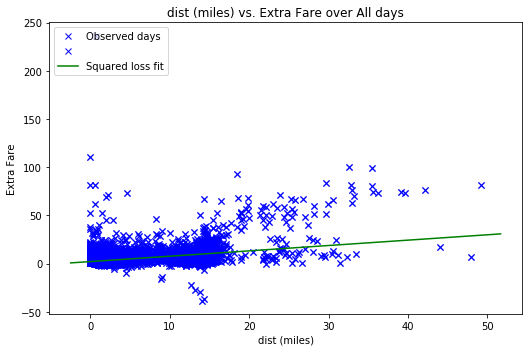

Least squared Error (Trip Duration (seconds)) 21.5731197976


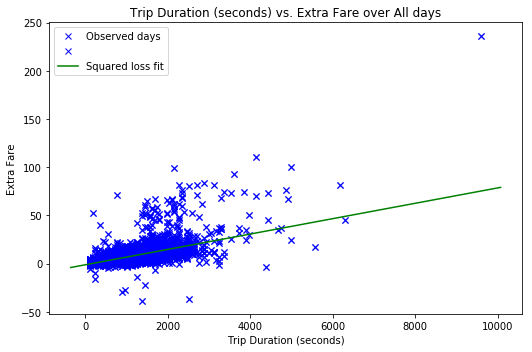

###########################
#### WEEKDAYS ####
###########################
Least squared Error (dist (miles)) 32.225766706


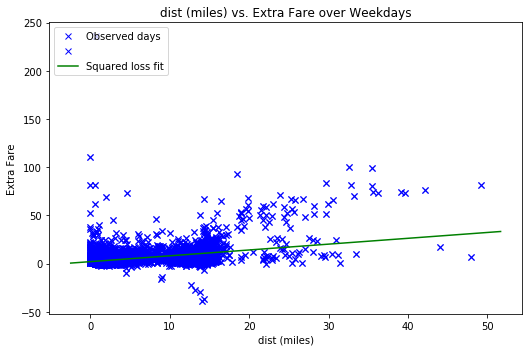

Least squared Error (Trip Duration (seconds)) 23.1876747331


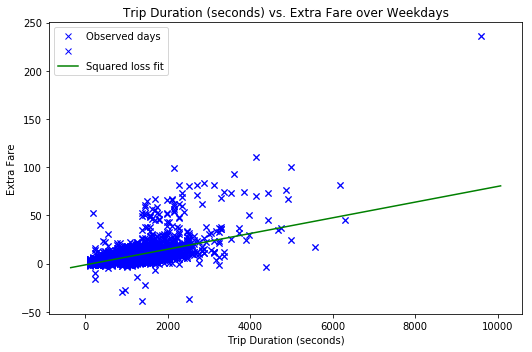

###########################
#### WEEKENDS ####
###########################
Least squared Error (dist (miles)) 18.5894573316


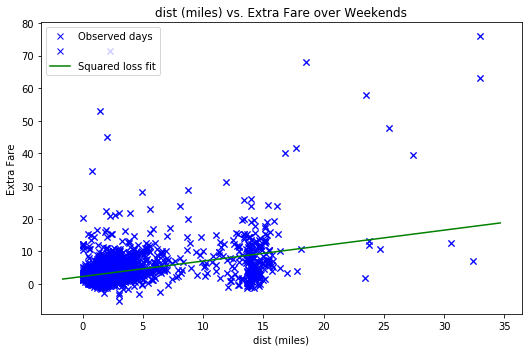

Least squared Error (Trip Duration (seconds)) 14.12968717


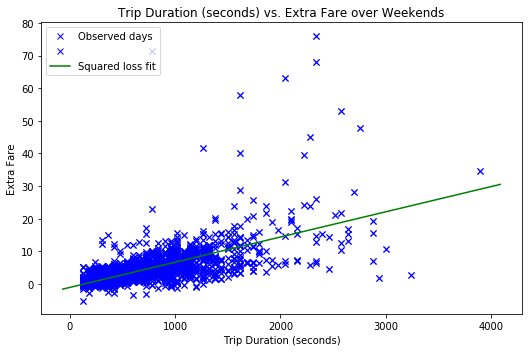

###########################
#### LEAVING SFO TRIPS ####
###########################
Least squared Error (dist (miles)) 133.346417284


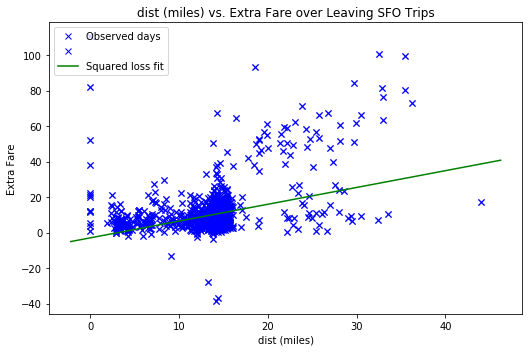

Least squared Error (Trip Duration (seconds)) 122.952676056


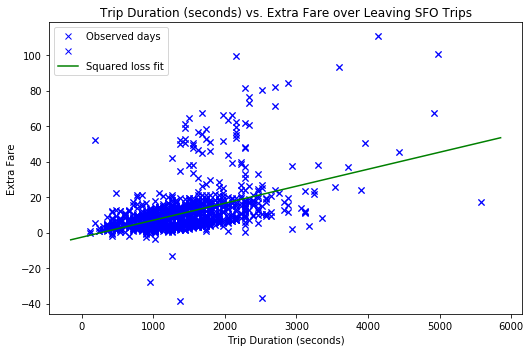

###########################
#### NOT LEAVING SFO TRIPS ####
###########################
Least squared Error (dist (miles)) 19.7554149008


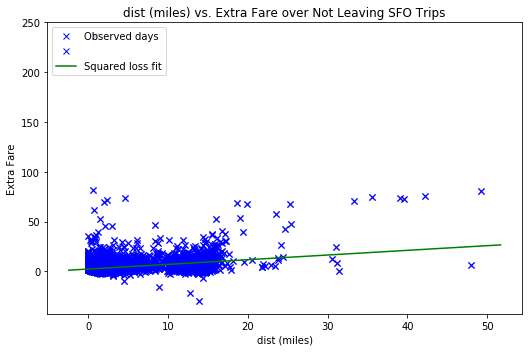

Least squared Error (Trip Duration (seconds)) 12.02536774


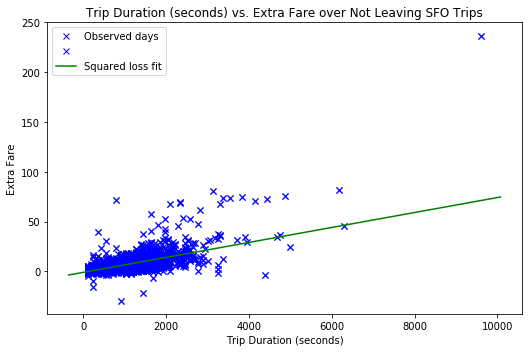

In [26]:
regress_on_distance_and_duration({
    "All days" : taxi_data,
    "Weekdays" : taxi_data_weekdays, 
    "Weekends" : taxi_data_weekends,
    "Leaving SFO Trips" : taxi_data_sfo,
    "Not Leaving SFO Trips" : taxi_data_not_sfo
})

In [27]:
To underst

SyntaxError: invalid syntax (<ipython-input-27-568036356339>, line 1)